<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/G_g_p_p0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import csv
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [45]:
distance = [np.sqrt(1/2), np.sqrt(2/2), np.sqrt(3/2), np.sqrt(4/2), np.sqrt(5/2), np.sqrt(6/2), np.sqrt(7/2), np.sqrt(8/2), np.sqrt(9/2), np.sqrt(10/2),
            np.sqrt(11/2), np.sqrt(12/2), np.sqrt(13/2), np.sqrt(14/2), np.sqrt(15/2), np.sqrt(16/2), np.sqrt(17/2), np.sqrt(18/2), np.sqrt(19/2), np.sqrt(20/2),
            np.sqrt(21/2), np.sqrt(22/2), np.sqrt(23/2), np.sqrt(24/2), np.sqrt(25/2), np.sqrt(26/2), np.sqrt(27/2)]
count = [12, 6, 24, 12, 24, 8, 48, 6, 36, 24,
         24, 24, 72, 0, 48, 12, 48, 30, 72, 24,
         48, 24, 48, 8, 84, 24, 96]
new_distances = [np.sqrt(x/16) for x in range(216)]

i=0
while i<3:
#  distance = np.insert(arr=distance, obj=range(len(distance)), values=0, axis=0)
  count = np.insert(arr=count, obj=range(len(count)), values=0, axis=0)
  i=i+1
#print(len(distance))
print(len(count))

print(len(new_distances))

216
216


In [37]:
np.sqrt(27/2)#*4.0789

3.6742346141747673

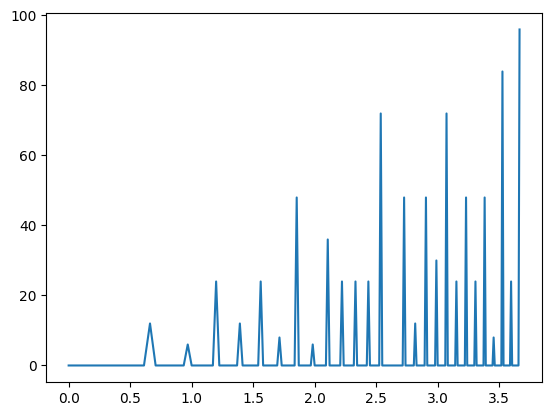

In [48]:
plt.plot(new_distances, count)

In [55]:
rho_r = np.multiply([1/(4*np.pi*x*x*sum(count)) for x in new_distances],count)
g_r = rho_r/(4*np.pi*new_distances[-1]*new_distances[-1]*new_distances[-1]/3)

<ipython-input-55-624cb93ac94c>:1: RuntimeWarning: divide by zero encountered in double_scalars
  rho_r = np.multiply([1/(4*np.pi*x*x*sum(count)) for x in new_distances],count)
<ipython-input-55-624cb93ac94c>:1: RuntimeWarning: invalid value encountered in multiply
  rho_r = np.multiply([1/(4*np.pi*x*x*sum(count)) for x in new_distances],count)


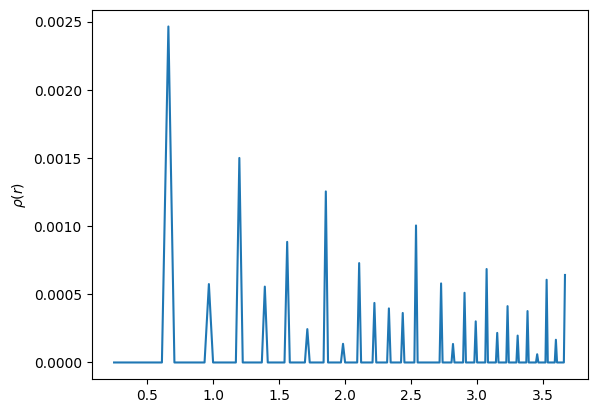

In [54]:
plt.plot(new_distances, rho_r)
plt.ylabel(r'$\rho(r)$');

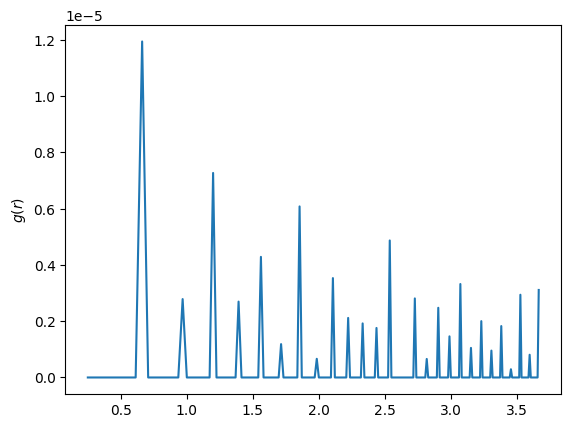

In [58]:
plt.plot(new_distances, g_r)
plt.ylabel(r'$g(r)$');

In [ ]:
0..
